In [1]:
import json
import re
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from matplotlib import ticker

In [2]:
from tqdm.auto import tqdm

tqdm.pandas()
matplotlib.rc_file_defaults()

In [3]:
dataset = iter(load_dataset("JetBrains-Research/jupyter-errors-dataset", split="train", streaming=True))
num_examples: int = 200
df = pd.DataFrame([next(dataset) for _ in tqdm(range(num_examples))]).set_index("id")
df.head()

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

repo_name           repo_owner  \
id                                           
0   finance-complaint  Machine-Learning-01   
1           langchain         langchain-ai   
2     deep_prediction          sapan-ostic   
3     cv-ferattn-code           HelenGuohx   
4      diseno_sci_sfw             leliel12   

                                            file_link  \
id                                                      
0   https://github.com/Machine-Learning-01/finance...   
1   https://github.com/langchain-ai/langchain/blob...   
2   https://github.com/sapan-ostic/deep_prediction...   
3   https://github.com/HelenGuohx/cv-ferattn-code/...   
4   https://github.com/leliel12/diseno_sci_sfw/blo...   

                                            line_link  \
id                                                      
0   https://github.com/Machine-Learning-01/finance...   
1   https://github.com/langchain-ai/langchain/blob...   
2   https://github.com/sapan-ostic/deep_prediction...   
3   https://github.com/HelenGuohx/cv-ferattn-code/...   
4   https://github.com/leliel12/diseno_sci_sfw/blo...   

                                                 path  \
id                                                      
0                            notebook/Untitled1.ipynb   
1   docs/extras/modules/model_io/output_parsers/en...   
2   scripts/.ipynb_checkpoints/test_argo-checkpoin...   
3                   fervideo/Facial_recognition.ipynb   
4     00_antecedentes/02_niveles_de_abstraccion.ipynb   

                                          content_sha  \
id                                                      
0   d12c58483c42f93f58d6943065e34ed0a636d6a5ae1732...   
1   e515f22c581952d6cb0b36104d398722c5186e06e301b4...   
2   7736c22796f980a4998a16ec0eb26d703d829be1d0c2ab...   
3   881e69a1e530676b4a28e425af897c09e8ebcc8037fc46...   
4   b0c26856e090641929400716e6906670c5fde357f3d560...   

                                              content  
id                                                     
0   {\n "cells": [\n  {\n   "cell_type": "code",\n...  
1   {\n "cells": [\n  {\n   "cell_type": "markdown...  
2   {\n "cells": [\n  {\n   "cell_type": "code",\n...  
3   {\n "cells": [\n  {\n   "cell_type": "markdown...  
4   {\n "cells": [\n  {\n   "attachments": {\n    ...

In [4]:
def safe_json_loads(json_str):
    try:
        return json.loads(json_str)
    except json.JSONDecodeError:
        return {}


def contains_error(output_list):
    for output in output_list:
        if isinstance(output, dict) and output.get("output_type") == "error":
            return True
    return False

In [5]:
df["json_column"] = df["content"].progress_apply(safe_json_loads)
df["cells"] = df["json_column"].apply(lambda row: row.get("cells", []))

df_cells = df.explode("cells")
df_cells["outputs"] = df_cells["cells"].apply(
    lambda cell: cell.get("outputs", None) if isinstance(cell, dict) else None
)

  0%|          | 0/200 [00:00<?, ?it/s]

In [6]:
df_outputs = df_cells[df_cells["outputs"].fillna("").apply(len) > 0]
df_outputs.loc[:, ["has_error"]] = df_outputs["outputs"].apply(contains_error)

In [7]:
df_errors = df_outputs[df_outputs["has_error"]]
df_errors = df_errors.drop(columns=["content", "json_column", "cells", "has_error"])
df_errors = df_errors.explode("outputs")

df_errors = df_errors[df_errors["outputs"].apply(lambda output: output.get("output_type") == "error")]

df_errors.loc[:, ["ename"]] = df_errors["outputs"].apply(lambda output: output.get("ename"))
df_errors.loc[:, ["traceback"]] = df_errors["outputs"].apply(lambda output: output.get("traceback"))

In [8]:
del df
del df_cells
del df_outputs

In [9]:
df_errors.head()

repo_name           repo_owner  \
id                                           
0   finance-complaint  Machine-Learning-01   
1           langchain         langchain-ai   
2     deep_prediction          sapan-ostic   
3     cv-ferattn-code           HelenGuohx   
4      diseno_sci_sfw             leliel12   

                                            file_link  \
id                                                      
0   https://github.com/Machine-Learning-01/finance...   
1   https://github.com/langchain-ai/langchain/blob...   
2   https://github.com/sapan-ostic/deep_prediction...   
3   https://github.com/HelenGuohx/cv-ferattn-code/...   
4   https://github.com/leliel12/diseno_sci_sfw/blo...   

                                            line_link  \
id                                                      
0   https://github.com/Machine-Learning-01/finance...   
1   https://github.com/langchain-ai/langchain/blob...   
2   https://github.com/sapan-ostic/deep_prediction...   
3   https://github.com/HelenGuohx/cv-ferattn-code/...   
4   https://github.com/leliel12/diseno_sci_sfw/blo...   

                                                 path  \
id                                                      
0                            notebook/Untitled1.ipynb   
1   docs/extras/modules/model_io/output_parsers/en...   
2   scripts/.ipynb_checkpoints/test_argo-checkpoin...   
3                   fervideo/Facial_recognition.ipynb   
4     00_antecedentes/02_niveles_de_abstraccion.ipynb   

                                          content_sha  \
id                                                      
0   d12c58483c42f93f58d6943065e34ed0a636d6a5ae1732...   
1   e515f22c581952d6cb0b36104d398722c5186e06e301b4...   
2   7736c22796f980a4998a16ec0eb26d703d829be1d0c2ab...   
3   881e69a1e530676b4a28e425af897c09e8ebcc8037fc46...   
4   b0c26856e090641929400716e6906670c5fde357f3d560...   

                                              outputs                  ename  \
id                                                                             
0   {'ename': 'TypeError', 'evalue': ''range' obje...              TypeError   
1   {'ename': 'OutputParserException', 'evalue': '...  OutputParserException   
2   {'ename': 'ValueError', 'evalue': 'operands co...             ValueError   
3   {'ename': 'TypeError', 'evalue': ''NoneType' o...              TypeError   
4   {'ename': 'TypeError', 'evalue': 'unsupported ...              TypeError   

                                            traceback  
id                                                     
0   [--------------------------------------...  
1   [--------------------------------------...  
2   [--------------------------------------...  
3   [--------------------------------------...  
4   [--------------------------------------...

In [10]:
error_counts = df_errors.ename.value_counts(normalize=True)
error_counts[:10]

ename
NameError              0.252525
TypeError              0.161616
AttributeError         0.124579
ValueError             0.121212
KeyError               0.050505
IndexError             0.033670
ModuleNotFoundError    0.026936
FileNotFoundError      0.023569
RuntimeError           0.020202
ImportError            0.016835
Name: proportion, dtype: float64

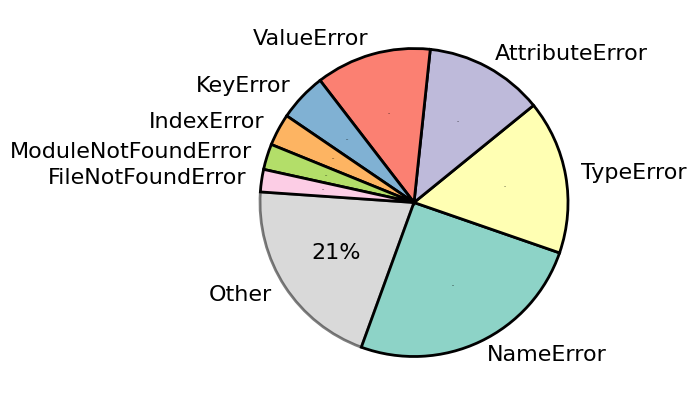

In [11]:
s: pd.Series = error_counts
top_num: int = 8

top8, other = s[:top_num], pd.Series([s[top_num:].sum()], index=["Other"])
data = pd.concat([top8, other])

edge_colors = ["green"] * len(top8)
edge_colors.append("black")

fig, ax = plt.subplots(figsize=(5, 5))
wedges, text, auto_texts = ax.pie(
    data, labels=data.index, startangle=250, colors=sns.color_palette("Set3", 12), autopct="%1.0f%%"
)

for i, (w, t, at) in enumerate(zip(wedges, text, auto_texts)):
    group = data.index[i]
    lw, fs = 2, 16

    z_order = 1 if group == "Other" else 2
    edge_color = (0, 0, 0, 0.5) if group == "Other" else "black"
    cell_fontsize = 16 if group == "Other" else 0

    w.set_edgecolor(edge_color)
    w.set_zorder(z_order)
    w.set_linewidth(lw)
    t.set_fontsize(fs)
    at.set_fontsize(cell_fontsize)

del auto_texts[1]

figures_path = Path("figures/")
fig.savefig(
    figures_path / "errors_distribution.pdf",
    bbox_inches="tight",
    dpi=300,
)

plt.show()

In [12]:
def parse_location(error: list[str]) -> str:
    patterns = [
        re.compile(r"\x1b\[1;32m(.*?)\x1b\[0m"),
        re.compile(r"\x1b\[0;32m(.*?)\x1b\[0m"),
    ]

    err_locations = []
    for line in error:
        for pattern in patterns:
            if loc := pattern.findall(line):
                err_locations.append(loc[0])

    loc = None if not err_locations else err_locations[-1]
    internal_flags = {"<ipython", "In[", "In ["}
    return "internal" if loc and any(flag in loc for flag in internal_flags) else "external"

In [13]:
df_errors["location"] = df_errors.traceback.progress_apply(
    lambda x: parse_location(eval(x) if isinstance(x, str) else x)
)

  0%|          | 0/297 [00:00<?, ?it/s]

In [14]:
df_errors.head()

repo_name           repo_owner  \
id                                           
0   finance-complaint  Machine-Learning-01   
1           langchain         langchain-ai   
2     deep_prediction          sapan-ostic   
3     cv-ferattn-code           HelenGuohx   
4      diseno_sci_sfw             leliel12   

                                            file_link  \
id                                                      
0   https://github.com/Machine-Learning-01/finance...   
1   https://github.com/langchain-ai/langchain/blob...   
2   https://github.com/sapan-ostic/deep_prediction...   
3   https://github.com/HelenGuohx/cv-ferattn-code/...   
4   https://github.com/leliel12/diseno_sci_sfw/blo...   

                                            line_link  \
id                                                      
0   https://github.com/Machine-Learning-01/finance...   
1   https://github.com/langchain-ai/langchain/blob...   
2   https://github.com/sapan-ostic/deep_prediction...   
3   https://github.com/HelenGuohx/cv-ferattn-code/...   
4   https://github.com/leliel12/diseno_sci_sfw/blo...   

                                                 path  \
id                                                      
0                            notebook/Untitled1.ipynb   
1   docs/extras/modules/model_io/output_parsers/en...   
2   scripts/.ipynb_checkpoints/test_argo-checkpoin...   
3                   fervideo/Facial_recognition.ipynb   
4     00_antecedentes/02_niveles_de_abstraccion.ipynb   

                                          content_sha  \
id                                                      
0   d12c58483c42f93f58d6943065e34ed0a636d6a5ae1732...   
1   e515f22c581952d6cb0b36104d398722c5186e06e301b4...   
2   7736c22796f980a4998a16ec0eb26d703d829be1d0c2ab...   
3   881e69a1e530676b4a28e425af897c09e8ebcc8037fc46...   
4   b0c26856e090641929400716e6906670c5fde357f3d560...   

                                              outputs                  ename  \
id                                                                             
0   {'ename': 'TypeError', 'evalue': ''range' obje...              TypeError   
1   {'ename': 'OutputParserException', 'evalue': '...  OutputParserException   
2   {'ename': 'ValueError', 'evalue': 'operands co...             ValueError   
3   {'ename': 'TypeError', 'evalue': ''NoneType' o...              TypeError   
4   {'ename': 'TypeError', 'evalue': 'unsupported ...              TypeError   

                                            traceback  location  
id                                                               
0   [--------------------------------------...  internal  
1   [--------------------------------------...  external  
2   [--------------------------------------...  internal  
3   [--------------------------------------...  external  
4   [--------------------------------------...  internal

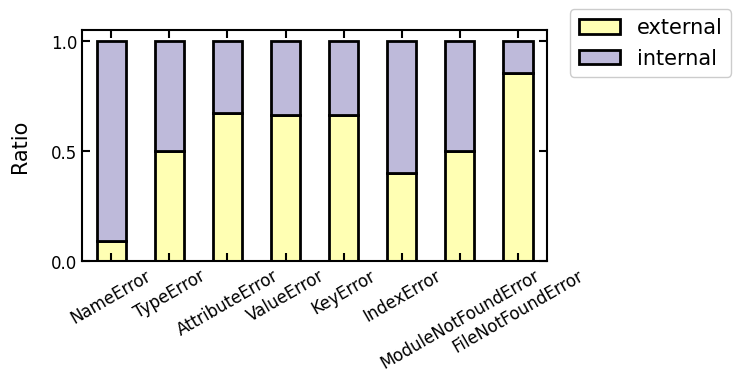

In [15]:
s: pd.Series = error_counts
top_num: int = 8

top_ename = list(s[:8].index)
df_filtered = df_errors[df_errors["ename"].isin(top_ename)].set_index("ename").loc[top_ename].reset_index()

df_grouped = (
    df_filtered.groupby(["ename", "location"]).size().unstack().apply(lambda x: x / x.sum(), axis=1).loc[top_ename]
)


fig, ax = plt.subplots(figsize=(6, 3))
df_grouped.plot(
    kind="bar", stacked=True, ax=ax, edgecolor="k", lw=2, color=sns.color_palette("Set3", 12)[1:3], legend=False
)

leg = ax.legend(loc=(1.05, 0.8), fontsize=15, framealpha=1)
label_params = {"fontsize": 15, "labelpad": 15}
ax.set_ylabel("Ratio", **label_params)
ax.set_xlabel("")

tick_params = {
    "direction": "in",
    "which": "both",
    "length": 6,
    "width": 1.5,
    "colors": "black",
    "labelsize": 12,
}

ax.tick_params(**tick_params)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.yaxis.set_major_locator(ticker.MaxNLocator(4))

for side in ["bottom", "top", "left", "right"]:
    ax.spines[side].set_linewidth(1.5)

ax.set_yticks([0, 0.5, 1])
plt.xticks(rotation=30)

figures_path = Path("figures/")
fig.savefig(
    figures_path / "external_internal_ratio.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()